# Rate Equation
## Objective
1. Define equation
2. Solve equation
3. Compute model and signal

```{note}
In this example, we only deal with gaussian and cauchy irf with same fwhm
```

In [1]:
# import needed module
import numpy as np
import matplotlib.pyplot as plt
from TRXASprefitpack import solve_model, compute_model, compute_signal_gau
from TRXASprefitpack import compute_signal_cauchy, compute_signal_pvoigt
plt.rcParams["figure.figsize"] = (14,10)

## basic information of functions

In [2]:
help(solve_model)

Help on function solve_model in module TRXASprefitpack.mathfun.rate_eq:

solve_model(equation, y0)
    Solve system of first order rate equation
    
    
    :param equation: matrix corresponding to model
    :type equation: numpy_nd_array
    :param y0: initial condition
    :type y0: numpy_1d_array
    
    
    :return: eigenvalue of equation
    :rtype: numpy_1d_array
    :return: eigenvectors for equation
    :rtype: numpy_nd_array
    :return: coefficient where y_0 = Vc
    :rtype: numpy_1d_array



In [3]:
help(compute_model)

Help on function compute_model in module TRXASprefitpack.mathfun.rate_eq:

compute_model(t, eigval, V, c)
    Compute solution of the system of rate equations solved by solve_model
    Note: eigval, V, c should be obtained from solve_model
    
    
    :param t: time
    :type t: numpy_1d_array
    :param eigval: eigenvalue for equation
    :type eigval: numpy_1d_array
    :param V: eigenvectors for equation
    :type V: numpy_nd_array
    :param c: coefficient
    :type c: numpy_1d_array
    
    
    :return: solution of rate equation
    :rtype: numpy_nd_array



In [4]:
help(compute_signal_gau)

Help on function compute_signal_gau in module TRXASprefitpack.mathfun.rate_eq:

compute_signal_gau(t, fwhm, eigval, V, c)
    Compute solution of the system of rate equations solved by solve_model
    convolved with normalized gaussian distribution
    Note: eigval, V, c should be obtained from solve_model
    
    
    :param t: time
    :type t: numpy_1d_array
    :param fwhm: full width at half maximum of x-ray temporal pulse
    :type fwhm: float
    :param eigval: eigenvalue for equation
    :type eigval: numpy_1d_array
    :param V: eigenvectors for equation
    :type V: numpy_nd_array
    :param c: coefficient
    :type c: numpy_1d_array
    
    
    :return: 
     solution of rate equation convolved with normalized gaussian distribution
    :rtype: numpy_nd_array



In [5]:
help(compute_signal_cauchy)

Help on function compute_signal_cauchy in module TRXASprefitpack.mathfun.rate_eq:

compute_signal_cauchy(t, fwhm, eigval, V, c)
    Compute solution of the system of rate equations solved by solve_model
    convolved with normalized cauchy distribution
    Note: eigval, V, c should be obtained from solve_model
    
    
    :param t: time
    :type t: numpy_1d_array
    :param fwhm: full width at half maximum of x-ray temporal pulse
    :type fwhm: float
    :param eigval: eigenvalue for equation
    :type eigval: numpy_1d_array
    :param V: eigenvectors for equation
    :type V: numpy_nd_array
    :param c: coefficient
    :type c: numpy_1d_array
    
    
    :return: 
     solution of rate equation convolved with normalized cachy distribution
    :rtype: numpy_nd_array



In [6]:
help(compute_signal_pvoigt)

Help on function compute_signal_pvoigt in module TRXASprefitpack.mathfun.rate_eq:

compute_signal_pvoigt(t, fwhm_G, fwhm_L, eta, eigval, V, c)
    Compute solution of the system of rate equations solved by solve_model
    convolved with normalized pseudo voigt profile
    (:math:`pvoigt = (1-\eta) G(t) + \eta L(t)`,
    G(t): stands for normalized gaussian
    L(t): stands for normalized cauchy(lorenzian) distribution)
    
    Note: eigval, V, c should be obtained from solve_model
    
    :param t: time
    :type t: numpy_1d_array
    :param fwhm_G: 
     full width at half maximum of x-ray temporal pulse (gaussian part)
    :type fwhm_G: float
    :param fwhm_L:
     full width at half maximum of x-ray temporal pulse (lorenzian part)
    :type fwhm_L: float
    :param float eta: mixing parameter :math:`(0 < \eta < 1)`
    
    :type eta: float
    :param eigval: eigenvalue for equation
    :type eigval: numpy_1d_array
    :param V: eigenvectors for equation
    :type V: numpy_nd_arr

## Define equation

```{note}
In pump-probe time resolved spectroscopy, 
the concentration of ground state is not much important.
Only, the concentration of excited species are matter.
```

Consider model
```{code-block} python
'''
    k1     k2
A  ---> B ---> GS
y1: A
y2: B
y3: GS
'''
```

with initial condition 
\begin{equation*}
y(t) = \begin{cases}
(0, 0, 1) & \text{if $t < 0$}, \\
(1, 0, 0) & \text{if $t=0$}.
\end{cases}
\end{equation*}

Then what we need to solve is

\begin{equation*}
y'(t) = \begin{cases}
(0, 0, 0) & \text{if $t < 0$}, \\
Ay(t) & \text{if $t \geq 0$}
\end{cases}
\end{equation*}

with $y(0)=y_0$.

Where $A$ is

\begin{equation*}
A = \begin{pmatrix}
-k_1 & 0 & 0 \\
k_1 & -k_2 & 0 \\
0 & k_2 & 0
\end{pmatrix}
\end{equation*}


In [7]:
# set lifetime tau1 = 10 ps, tau2 = 1 ns
# set fwhm of IRF = 1 ps

tau1 = 10
tau2 = 1000
fwhm = 1

# initial condition
y0 = np.array([1, 0, 0])

# set time range
t_short = np.arange(-10,50,0.1)
t_long = np.arange(-200,5000,10)

# Define equation
equation = np.array([[-1/tau1, 0, 0],
                    [1/tau1, -1/tau2, 0],
                    [0, 1/tau2, 0]])

# Solve equation
eigval, V, c = solve_model(equation, y0)

In [8]:
# Now compute model
y_short = compute_model(t_short, eigval, V, c)
y_long = compute_model(t_long, eigval, V, c)

#Next compute signal (model convolved with irf)
signal_short = compute_signal_gau(t_short, fwhm, eigval, V, c)
signal_long = compute_signal_gau(t_long, fwhm, eigval, V, c)
signal_short_cauchy = compute_signal_cauchy(t_short, fwhm, eigval, V, c)
signal_long_cauchy = compute_signal_cauchy(t_long, fwhm, eigval, V, c)

# since, y_1 + y_2 + y_3 = 1 for all t,
# y3 = 1 - (y_1+y_2)

y_short[-1, :] = 1 - (y_short[0, :] + y_short[1, :])
y_long[-1, :] = 1 - (y_long[0, :] + y_long[1, :])
signal_short[-1, :] = 1 - (signal_short[0, :] + signal_short[1, :])
signal_long[-1, :] = 1 - (signal_long[0, :] + signal_long[1, :])
signal_short_cauchy[-1, :] = 1 - (signal_short_cauchy[0, :] + signal_short_cauchy[1, :])
signal_long_cauchy[-1, :] = 1 - (signal_long_cauchy[0, :] + signal_long_cauchy[1, :])

## plot model
1. short range

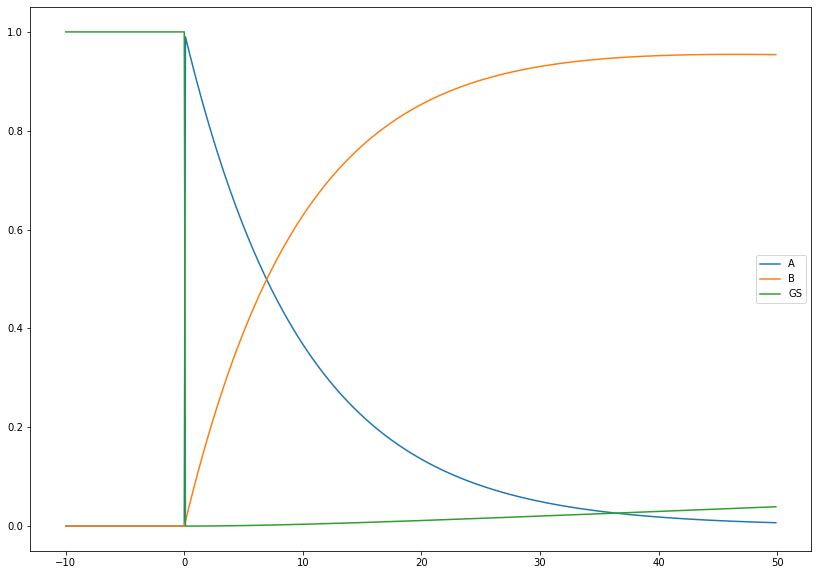

In [9]:
plt.plot(t_short, y_short[0, :], label='A')
plt.plot(t_short, y_short[1, :], label='B')
plt.plot(t_short, y_short[2, :], label='GS')
plt.legend()
plt.show()

2. long range

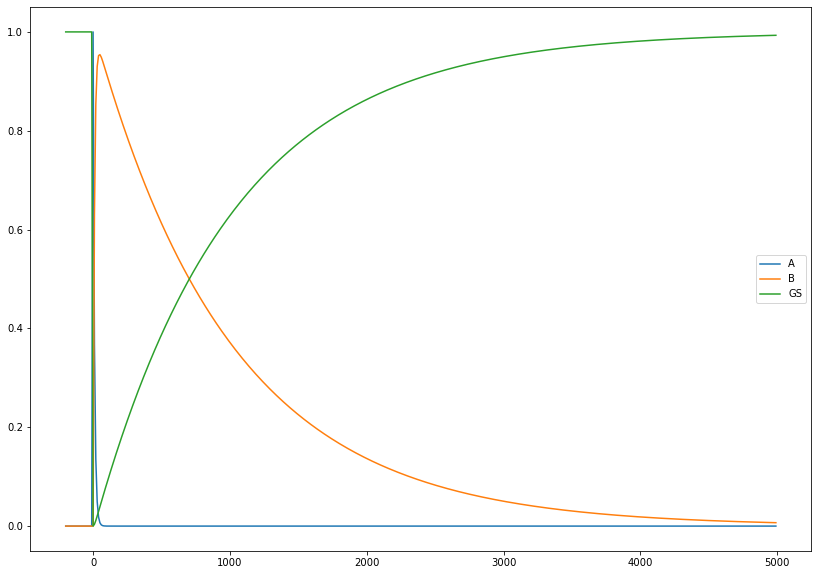

In [10]:
plt.plot(t_long, y_long[0, :], label='A')
plt.plot(t_long, y_long[1, :], label='B')
plt.plot(t_long, y_long[2, :], label='GS')
plt.legend()
plt.show()

## plot signal (gaussian)
1. short range

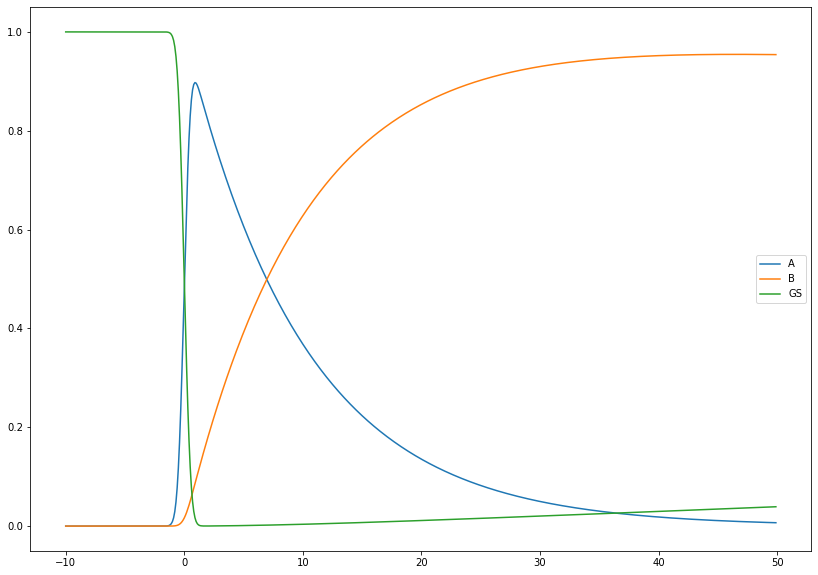

In [11]:
plt.plot(t_short, signal_short[0, :], label='A')
plt.plot(t_short, signal_short[1, :], label='B')
plt.plot(t_short, signal_short[2, :], label='GS')
plt.legend()
plt.show()

2. long range

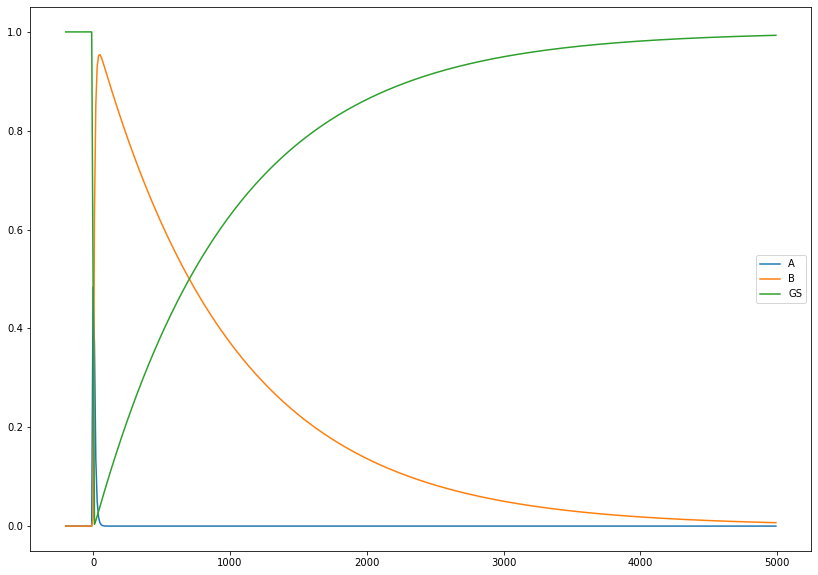

In [12]:
plt.plot(t_long, signal_long[0, :], label='A')
plt.plot(t_long, signal_long[1, :], label='B')
plt.plot(t_long, signal_long[2, :], label='GS')
plt.legend()
plt.show()

## plot signal (Cauchy)
1. short range

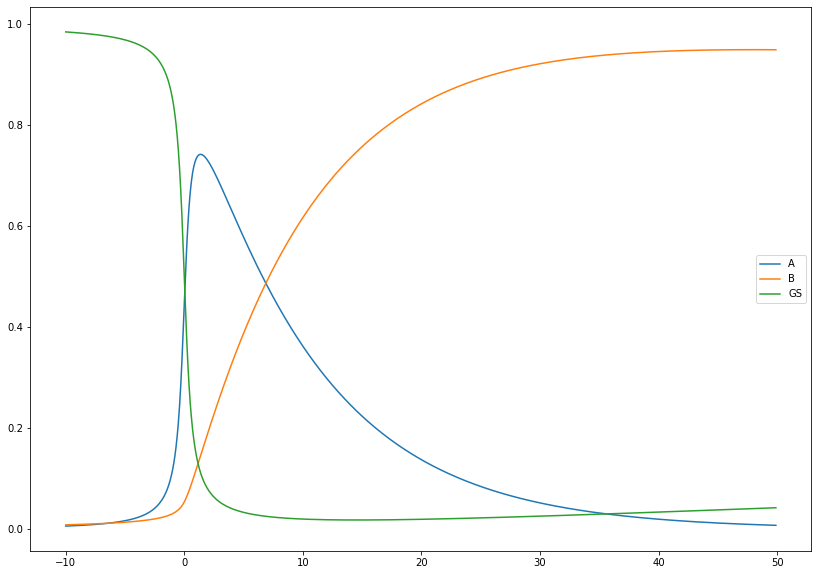

In [13]:
plt.plot(t_short, signal_short_cauchy[0, :], label='A')
plt.plot(t_short, signal_short_cauchy[1, :], label='B')
plt.plot(t_short, signal_short_cauchy[2, :], label='GS')
plt.legend()
plt.show()

2. long range

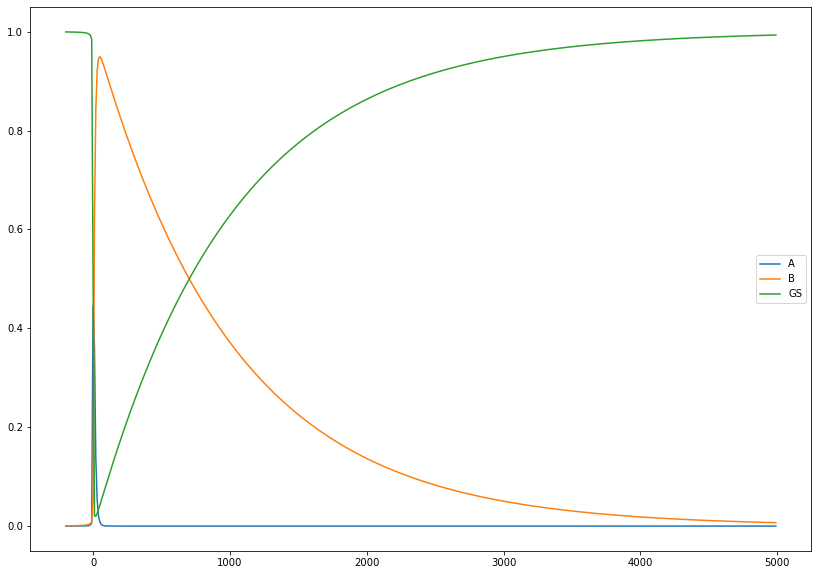

In [14]:
plt.plot(t_long, signal_long_cauchy[0, :], label='A')
plt.plot(t_long, signal_long_cauchy[1, :], label='B')
plt.plot(t_long, signal_long_cauchy[2, :], label='GS')
plt.legend()
plt.show()

## Conclusion
1. IRF broads the signal
2. At short range, gaussian signal is much sharper than cauchy signal.
3. At long range, gaussian signal and cauchy signal look similar.